In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import cython

from typing import Tuple
from cython.parallel import prange

In [2]:
%load_ext Cython

In [3]:
from typing import Tuple

import numpy as np
from numba import njit

from CyRK import nbrk_ode

nbrk_ode_py = nbrk_ode.py_func

In [24]:
%%cython --annotate --force
# distutils: extra_compile_args=-fopenmp
# distutils: extra_link_args=-fopenmp

import cython
import numpy as np
cimport numpy as np
from libc.math cimport sqrt
from cython.parallel import parallel, prange
from cpython cimport array
from libc.stdlib cimport malloc, free


from numpy.core.multiarray import (interp as compiled_interp, interp_complex as compiled_interp_complex
    )

np.import_array()

# Multiply steps computed from asymptotic behaviour of errors by this.
cdef double SAFETY = 0.9

cdef double MIN_FACTOR = 0.2  # Minimum allowed decrease in a step size.
cdef double MAX_FACTOR = 10.  # Maximum allowed increase in a step size.
cdef double MAX_STEP = np.inf
cdef double INF = np.inf

cdef double EPS = np.finfo(np.float64).eps
cdef double EPS_10 = EPS * 10.
cdef double EPS_100 = EPS * 100.


unused_t_eval = np.empty((0,), dtype=np.float64)

# RK23 Constants
cdef double RK23_C[3]
cdef double complex RK23_B[3]
cdef double complex RK23_E[4]
cdef double complex RK23_A[3][3]
cdef unsigned int RK23_order = 3
cdef unsigned int RK23_error_order = 2
cdef unsigned int RK23_n_stages = 3
RK23_C[:] = [0, 1 / 2, 3 / 4]
cdef unsigned int RK23_LEN_C = 3
RK23_B[:] = [2 / 9, 1 / 3, 4 / 9]
RK23_E[:] = [5 / 72, -1 / 12, -1 / 9, 1 / 8]

RK23_A[0][:] = [0, 0, 0]
RK23_A[1][:] = [1 / 2, 0, 0]
RK23_A[2][:] = [0, 3 / 4, 0]

# RK45 Constants
cdef double RK45_C[6]
cdef double complex RK45_B[6]
cdef double complex RK45_E[7]
cdef double complex RK45_A[6][5]
cdef unsigned int RK45_order = 5
cdef unsigned int RK45_error_order = 4
cdef unsigned int RK45_n_stages = 6
RK45_C[:] = [0, 1 / 5, 3 / 10, 4 / 5, 8 / 9, 1]
cdef unsigned int RK45_LEN_C = 6
RK45_B[:] = [35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84]
RK45_E[:] = [-71 / 57600, 0, 71 / 16695, -71 / 1920, 17253 / 339200, -22 / 525, 1 / 40]

RK45_A[0][:] = [0, 0, 0, 0, 0]
RK45_A[1][:] = [1 / 5, 0, 0, 0, 0]
RK45_A[2][:] = [3 / 40, 9 / 40, 0, 0, 0]
RK45_A[3][:] = [44 / 45, -56 / 15, 32 / 9, 0, 0]
RK45_A[4][:] = [19372 / 6561, -25360 / 2187, 64448 / 6561, -212 / 729, 0]
RK45_A[5][:] = [9017 / 3168, -355 / 33, 46732 / 5247, 49 / 176, -5103 / 18656]

# DOP863 Constants

cdef int j_, i_
cdef unsigned int DOP_order = 8
cdef unsigned int DOP_error_order = 7
cdef unsigned int DOP_n_stages = 12
cdef unsigned int DOP_n_stages_extended = 16
cdef double DOP_C[16]
DOP_C = [
    0.0,
    0.526001519587677318785587544488e-01,
    0.789002279381515978178381316732e-01,
    0.118350341907227396726757197510,
    0.281649658092772603273242802490,
    0.333333333333333333333333333333,
    0.25,
    0.307692307692307692307692307692,
    0.651282051282051282051282051282,
    0.6,
    0.857142857142857142857142857142,
    1.0,
    1.0,
    0.1,
    0.2,
    0.777777777777777777777777777778]

cdef double DOP_C_REDUCED[12]
for i_ in range(12):
    DOP_C_REDUCED[i_] = DOP_C[i_]
cdef unsigned int DOP_LEN_C = 12

cdef double complex DOP_A[16][16]
for j_ in range(16):
    for i_ in range(16):
        DOP_A[i_][j_] = 0.

DOP_A[1][0] = 5.26001519587677318785587544488e-2

DOP_A[2][0] = 1.97250569845378994544595329183e-2
DOP_A[2][1] = 5.91751709536136983633785987549e-2

DOP_A[3][0] = 2.95875854768068491816892993775e-2
DOP_A[3][2] = 8.87627564304205475450678981324e-2

DOP_A[4][0] = 2.41365134159266685502369798665e-1
DOP_A[4][2] = -8.84549479328286085344864962717e-1
DOP_A[4][3] = 9.24834003261792003115737966543e-1

DOP_A[5][0] = 3.7037037037037037037037037037e-2
DOP_A[5][3] = 1.70828608729473871279604482173e-1
DOP_A[5][4] = 1.25467687566822425016691814123e-1

DOP_A[6][0] = 3.7109375e-2
DOP_A[6][3] = 1.70252211019544039314978060272e-1
DOP_A[6][4] = 6.02165389804559606850219397283e-2
DOP_A[6][5] = -1.7578125e-2

DOP_A[7][0] = 3.70920001185047927108779319836e-2
DOP_A[7][3] = 1.70383925712239993810214054705e-1
DOP_A[7][4] = 1.07262030446373284651809199168e-1
DOP_A[7][5] = -1.53194377486244017527936158236e-2
DOP_A[7][6] = 8.27378916381402288758473766002e-3

DOP_A[8][0] = 6.24110958716075717114429577812e-1
DOP_A[8][3] = -3.36089262944694129406857109825
DOP_A[8][4] = -8.68219346841726006818189891453e-1
DOP_A[8][5] = 2.75920996994467083049415600797e1
DOP_A[8][6] = 2.01540675504778934086186788979e1
DOP_A[8][7] = -4.34898841810699588477366255144e1

DOP_A[9][0] = 4.77662536438264365890433908527e-1
DOP_A[9][3] = -2.48811461997166764192642586468
DOP_A[9][4] = -5.90290826836842996371446475743e-1
DOP_A[9][5] = 2.12300514481811942347288949897e1
DOP_A[9][6] = 1.52792336328824235832596922938e1
DOP_A[9][7] = -3.32882109689848629194453265587e1
DOP_A[9][8] = -2.03312017085086261358222928593e-2

DOP_A[10][0] = -9.3714243008598732571704021658e-1
DOP_A[10][3] = 5.18637242884406370830023853209
DOP_A[10][4] = 1.09143734899672957818500254654
DOP_A[10][5] = -8.14978701074692612513997267357
DOP_A[10][6] = -1.85200656599969598641566180701e1
DOP_A[10][7] = 2.27394870993505042818970056734e1
DOP_A[10][8] = 2.49360555267965238987089396762
DOP_A[10][9] = -3.0467644718982195003823669022

DOP_A[11][0] = 2.27331014751653820792359768449
DOP_A[11][3] = -1.05344954667372501984066689879e1
DOP_A[11][4] = -2.00087205822486249909675718444
DOP_A[11][5] = -1.79589318631187989172765950534e1
DOP_A[11][6] = 2.79488845294199600508499808837e1
DOP_A[11][7] = -2.85899827713502369474065508674
DOP_A[11][8] = -8.87285693353062954433549289258
DOP_A[11][9] = 1.23605671757943030647266201528e1
DOP_A[11][10] = 6.43392746015763530355970484046e-1

DOP_A[12][0] = 5.42937341165687622380535766363e-2
DOP_A[12][5] = 4.45031289275240888144113950566
DOP_A[12][6] = 1.89151789931450038304281599044
DOP_A[12][7] = -5.8012039600105847814672114227
DOP_A[12][8] = 3.1116436695781989440891606237e-1
DOP_A[12][9] = -1.52160949662516078556178806805e-1
DOP_A[12][10] = 2.01365400804030348374776537501e-1
DOP_A[12][11] = 4.47106157277725905176885569043e-2

DOP_A[13][0] = 5.61675022830479523392909219681e-2
DOP_A[13][6] = 2.53500210216624811088794765333e-1
DOP_A[13][7] = -2.46239037470802489917441475441e-1
DOP_A[13][8] = -1.24191423263816360469010140626e-1
DOP_A[13][9] = 1.5329179827876569731206322685e-1
DOP_A[13][10] = 8.20105229563468988491666602057e-3
DOP_A[13][11] = 7.56789766054569976138603589584e-3
DOP_A[13][12] = -8.298e-3

DOP_A[14][0] = 3.18346481635021405060768473261e-2
DOP_A[14][5] = 2.83009096723667755288322961402e-2
DOP_A[14][6] = 5.35419883074385676223797384372e-2
DOP_A[14][7] = -5.49237485713909884646569340306e-2
DOP_A[14][10] = -1.08347328697249322858509316994e-4
DOP_A[14][11] = 3.82571090835658412954920192323e-4
DOP_A[14][12] = -3.40465008687404560802977114492e-4
DOP_A[14][13] = 1.41312443674632500278074618366e-1

DOP_A[15][0] = -4.28896301583791923408573538692e-1
DOP_A[15][5] = -4.69762141536116384314449447206
DOP_A[15][6] = 7.68342119606259904184240953878
DOP_A[15][7] = 4.06898981839711007970213554331
DOP_A[15][8] = 3.56727187455281109270669543021e-1
DOP_A[15][12] = -1.39902416515901462129418009734e-3
DOP_A[15][13] = 2.9475147891527723389556272149
DOP_A[15][14] = -9.15095847217987001081870187138

cdef double complex DOP_A_REDUCED[12][12]
for j_ in range(12):
    for i_ in range(12):
        DOP_A_REDUCED[i_][j_] = DOP_A[i_][j_]

cdef double complex DOP_B[12]
for i_ in range(12):
    DOP_B[i_] = DOP_A[12][i_]

cdef double complex DOP_E3[13]
for i_ in range(13):
    if i_ == 12:
        DOP_E3[i_] = 0.
    else:
        DOP_E3[i_] = DOP_B[i_]
DOP_E3[0] -= 0.244094488188976377952755905512
DOP_E3[8] -= 0.733846688281611857341361741547
DOP_E3[11] -= 0.220588235294117647058823529412e-1


cdef double complex DOP_E5[13]
for i_ in range(13):
    DOP_E5[i_] = 0.
DOP_E5[0] = 0.1312004499419488073250102996e-1
DOP_E5[5] = -0.1225156446376204440720569753e+1
DOP_E5[6] = -0.4957589496572501915214079952
DOP_E5[7] = 0.1664377182454986536961530415e+1
DOP_E5[8] = -0.3503288487499736816886487290
DOP_E5[9] = 0.3341791187130174790297318841
DOP_E5[10] = 0.8192320648511571246570742613e-1
DOP_E5[11] = -0.2235530786388629525884427845e-1

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
#@cython.nonecheck(False)
def rk_integrate_cy(
    diffeq,
    (double, double) t_span, 
    np.ndarray[np.complex128_t, ndim=1] y0, 
    tuple args = tuple(),
    double rtol = 1.e-6, 
    double atol = 1.e-8,
    double max_step = MAX_STEP, 
    double first_step = 0.,
    unsigned int rk_method = 1,
    np.ndarray[np.float64_t, ndim=1] t_eval = unused_t_eval
    ):
    """ A Numba-safe Rugge-Kutta Integrator based on Scipy's solve_ivp RK integrator.

    Parameters
    ----------
    diffeq : callable
        An njit-compiled function that defines the derivatives of the problem.
    t_span : Tuple[float, float]
        A tuple of the beginning and end of the integration domain's dependent variables.
    y0 : np.ndarray
        1D array of the initial values of the problem at t_span[0]
    args : tuple = tuple()
        Any additional arguments that are passed to dffeq.
    rtol : float = 1.e-6
        Integration relative tolerance used to determine optimal step size.
    atol : float = 1.e-8
        Integration absolute tolerance used to determine optimal step size.
    max_step : float = np.inf
        Maximum allowed step size.
    first_step : float = None
        Initial step size. If `None`, then the function will attempt to determine an appropriate initial step.
    rk_method : int = 1
        The type of RK method used for integration
            0 = RK23
            1 = RK45
            2 = DOP853
    t_eval : np.ndarray = None
        If provided, then the function will interpolate the integration results to provide them at the
            requested t-steps.

    Returns
    -------
    time_domain : np.ndarray
        The final time domain. This is equal to t_eval if it was provided.
    y_results : np.ndarray
        The solution of the differential equation provided for each time_result.
    success : bool
        Final integration success flag.
    message : str
        Any integration messages, useful if success=False.

    """
    global RK23_C, RK23_B, RK23_E, RK23_A
    global RK45_C, RK45_B, RK45_E, RK45_A
    
    
    complex_type = np.complex128
    float_type = np.float64
    
    cdef unsigned int y_size
    # y-array
    y0 = np.asarray(y0)
    y_size = y0.size
    dtype = y0.dtype
    
    cdef list time_domain_list, y_results_list
    cdef str message, rejected_message
    cdef (unsigned int, unsigned int) K_size, result_size, reduced_result_size
    cdef bint success, step_accepted, step_rejected, step_error = False
    cdef unsigned int s, i, j, rk_order, error_order, rk_n_stages, rk_n_stages_plus1, len_c, len_t, \
        len_teval, rk_n_stages_extended
    cdef int status
    cdef double t_start, t_end, t_delta, t_delta_abs, t_init_step, \
        error_expo, error_norm, error_norm5, error_norm3, error_denom, error_norm3_abs, error_norm5_abs, error_norm_abs, \
        direction, h0_direction, d0, d1, d2, h0, h1, step_size, time_, min_step, step_factor, c, \
        d0_abs, d1_abs, d2_abs, y_size_sqrt, y_size_dbl
    cdef double complex K_scale
    cdef np.ndarray[np.float64_t, ndim=1] scale, time_domain
    cdef np.ndarray[np.complex128_t, ndim=1] y_new, y_old, y_tmp, y_init_step, dydt_new, dydt_old, dydt_init_step, \
        diffeq_out, y_result_temp, E_tmp, y_result_timeslice, \
        E3_tmp, E5_tmp
    cdef np.ndarray[np.complex128_t, ndim=2] y_results, y_results_reduced, K
    cdef double[:] scale_view, C
    cdef double complex[:]  y_init_step_view, y_new_view, \
        y_old_view, dydt_new_view, dydt_old_view, dydt_init_step_view, y_tmp_view, diffeq_out_view, \
        E_tmp_view, B, E, E3, E5, E3_tmp_view, E5_tmp_view
    cdef double complex[:, :] K_view, y_results_reduced_view, A
    
    # Clean up and interpret inputs
    # Time Domain
    t_start = t_span[0]
    t_end = t_span[1]
    t_delta = t_end - t_start
    t_delta_abs = abs(t_delta)
    if t_delta >= 0.:
        direction = 1.
    else:
        direction = -1.
    len_teval = t_eval.size
    y_size_dbl = <double>y_size
    y_size_sqrt = sqrt(y_size_dbl)
    
    # Set flags
    success = False
    step_accepted = False
    step_rejected = False
    step_error = False
    
    # Start storing results with the initial conditions
    time_domain_list = [t_start]
    y_results_list = [y0]
    
    # Initialize arrays
    scale              = np.empty(y_size, dtype=float_type)
    y_init_step        = np.empty(y_size, dtype=complex_type)
    y_new              = np.empty(y_size, dtype=complex_type)
    y_old              = np.empty(y_size, dtype=complex_type)
    dydt_new           = np.empty(y_size, dtype=complex_type)
    dydt_old           = np.empty(y_size, dtype=complex_type)
    dydt_init_step     = np.empty(y_size, dtype=complex_type)
    y_tmp              = np.empty(y_size, dtype=complex_type)
    diffeq_out         = np.empty(y_size, dtype=complex_type)
    
    # Setup memoryviews
    scale_view              = scale
    y_init_step_view        = y_init_step
    y_new_view              = y_new
    y_old_view              = y_old
    dydt_new_view           = dydt_new
    dydt_old_view           = dydt_old
    dydt_init_step_view     = dydt_init_step
    y_tmp_view              = y_tmp
    diffeq_out_view         = diffeq_out

    # Integrator Status Codes
    #   0  = Running
    #   -1 = Failed
    #   1  = Finished with no obvious issues
    status = 0

    # Determine RK constants
    if rk_method == 0:
        # RK23 Method
        rk_order = RK23_order
        error_order = RK23_error_order
        rk_n_stages = RK23_n_stages
        C = RK23_C
        A = RK23_A
        B = RK23_B
        E = RK23_E
        len_c = RK23_LEN_C
        
        E_tmp = np.zeros(y_size, dtype=complex_type)
        E_tmp_view = E_tmp
        
    elif rk_method == 1:
        # RK45 Method
        rk_order = RK45_order
        error_order = RK45_error_order
        rk_n_stages = RK45_n_stages
        C = RK45_C
        A = RK45_A
        B = RK45_B
        E = RK45_E
        len_c = RK45_LEN_C
        
        E_tmp = np.zeros(y_size, dtype=complex_type)
        E_tmp_view = E_tmp
    
    else:
        # DOP853 Method
        rk_order = DOP_order
        error_order = DOP_error_order
        rk_n_stages = DOP_n_stages
        rk_n_stages_extended = DOP_n_stages_extended
        C = DOP_C_REDUCED
        A = DOP_A_REDUCED
        B = DOP_B
        E3 = DOP_E3
        E5 = DOP_E5
        len_c = DOP_LEN_C

        E3_tmp = np.zeros(y_size, dtype=complex_type)
        E5_tmp = np.zeros(y_size, dtype=complex_type)
        E3_tmp_view = E3_tmp
        E5_tmp_view = E5_tmp
    
    error_expo = 1. / (<double>error_order + 1.)

    # Check tolerances
    if rtol < EPS_100:
        rtol = EPS_100

#     atol_arr = np.asarray(atol, dtype=np.complex128)
#     if atol_arr.ndim > 0 and atol_arr.shape[0] != y_size:
#         # atol must be either the same for all y or must be provided as an array, one for each y.
#         raise Exception

    # Initialize variables for start of integration
    diffeq(
        t_start,
        y0,
        dydt_new,
        *args
    )
    t_old = t_start
    t_new = t_start
    for i in range(y_size):
        dydt_old_view[i] = dydt_new_view[i]
        y_old_view[i] = y0[i]
        y_new_view[i] = y0[i]

    if first_step == 0.:
        # Select an initial step size based on the differential equation.
        # .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
        #        Equations I: Nonstiff Problems", Sec. II.4.
        if y_size == 0:
            step_size = INF
        else:
            # Find the norm for d0 and d1
            d0 = 0.
            d1 = 0.
            for i in range(y_size):
                scale_view[i] = atol + abs(y_old_view[i]) * rtol
            
                d0_abs = abs(y_old_view[i] / scale_view[i])
                d1_abs = abs(dydt_old_view[i] / scale_view[i])    
                d0 += (d0_abs * d0_abs)
                d1 += (d1_abs * d1_abs)
            
            d0 = sqrt(d0) / y_size_sqrt
            d1 = sqrt(d1) / y_size_sqrt
            
            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            h0_direction = h0 * direction
            t_init_step = t_old + h0_direction
            for i in range(y_size):
                y_init_step_view[i] = y_old_view[i] + h0_direction * dydt_old_view[i]

            diffeq(
                t_init_step,
                y_init_step,
                dydt_init_step,
                *args
            )
            
            # Find the norm for d2
            d2 = 0.
            for i in range(y_size):
                d2_abs = abs( (dydt_init_step_view[i] - dydt_old_view[i]) / scale_view[i] )
                d2 += (d2_abs * d2_abs)
            
            d2 = sqrt(d2) / (h0 * y_size_sqrt)

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = max(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / max(d1, d2))**error_expo

            step_size = min(100. * h0, h1)
    else:
        if first_step <= 0.:
            # Step size must be a positive number
            raise Exception
        elif first_step > t_delta_abs:
            # Step size can not exceed bounds
            raise Exception
        step_size = first_step

    # Initialize RK-K variable
    rk_n_stages_plus1 = rk_n_stages + 1
    K_size = (rk_n_stages_plus1, y_size)
    K = np.zeros(K_size, dtype=complex_type)
    
    # Setup K memoryviews
    K_view = K

    # Main integration loop
    message = 'Running...'
    # # Time Loop
    len_t = 1  # There is an initial condition provided so the time length is already 1
    while status == 0:

        if t_new == t_end or y_size == 0:
            t_old = t_end
            t_new = t_end
            message = 'Finished'
            status = 1
            break

        # Run RK integration step
        # Determine step size based on previous loop
        min_step = EPS_10
        # Look for over/undershoots in previous step size
        if step_size > max_step:
            step_size = max_step
        elif step_size < min_step:
            step_size = min_step

        # Determine new step size
        step_accepted = False
        step_rejected = False
        step_error = False
        rejected_message = 'Proper step size not found.'

        # # Step Loop
        while not step_accepted:

            if step_size < min_step:
                step_error = True
                rejected_message = 'Required step size is less than spacing between numbers.'
                break

            # Move time forward for this particular step size
            step = step_size * direction
            t_new = t_old + step

            # Check that we are not at the end of integration with that move
            if direction * (t_new - t_end) > 0:
                t_new = t_end

            # Correct the step if we were at the end of integration
            step = t_new - t_old
            step_size = abs(step)

            # Calculate derivative using RK method
            for i in range(y_size):
                K_view[0, i] = dydt_old_view[i]

            for s in range(1, len_c):

                c = C[s]
                time_ = t_new + c * step
                
                # Dot Product (K, a) * step
                for j in range(s):
                    for i in range(y_size):
                        if j == 0:
                            # Initialize
                            y_tmp_view[i] = y_old_view[i]

                        y_tmp_view[i] = y_tmp_view[i] + (K_view[j, i] * A[s, j] * step)

                diffeq(
                    time_,
                    y_tmp,
                    diffeq_out,
                    *args
                )
                
                for i in range(y_size):
                    K_view[s, i] = diffeq_out_view[i]
            
            # Dot Product (K, B) * step
            for j in range(rk_n_stages_plus1):                    
                for i in range(y_size):
                    if j == 0:
                        # Initialize
                        y_new_view[i] = y_old_view[i]
                    
                    y_new_view[i] = y_new_view[i] + (K_view[j, i] * B[j] * step)

            diffeq(
                t_new + step,
                y_new,
                dydt_new,
                *args
            )
            
            if rk_method == 2:
                # Calculate Error for DOP853
                
                # Dot Product (K, E5) / scale and Dot Product (K, E3) * step / scale
                for i in range(y_size):

                    # Check how well this step performed.
                    scale_view[i] = atol + max(abs(y_old_view[i]), abs(y_new_view[i])) * rtol

                    for j in range(rk_n_stages_plus1):
                        

                        if j == 0:
                            # Initialize
                            E5_tmp_view[i] = 0.
                            E3_tmp_view[i] = 0.
                            
                        elif j == rk_n_stages:
                            # Set last array of the K array.
                            K_view[j, i] = dydt_new_view[i]
                        
                        K_scale = K_view[j, i] / scale_view[i]
                        E5_tmp_view[i] = E5_tmp_view[i] + (K_scale * E5[j])
                        E3_tmp_view[i] = E3_tmp_view[i] + (K_scale * E3[j])

                # Find norms for each error
                error_norm5 = 0.
                error_norm3 = 0.

                # Perform summation
                for i in range(y_size):
                    error_norm5_abs = abs(E5_tmp_view[i])
                    error_norm3_abs = abs(E3_tmp_view[i])
                    
                    error_norm5 += (error_norm5_abs * error_norm5_abs)
                    error_norm3 += (error_norm3_abs * error_norm3_abs)
                
                # Check if errors are zero
                if (error_norm5 == 0.) and (error_norm3 == 0.):
                    error_norm = 0.
                else:
                    error_denom = error_norm5 + 0.01 * error_norm3
                    error_norm = step_size * error_norm5 / sqrt(error_denom * y_size_dbl)
                    
            else:
                # Calculate Error for RK23 and RK45
                error_norm = 0.
                # Dot Product (K, E) * step / scale
                for i in range(y_size):

                    # Check how well this step performed.
                    scale_view[i] = atol + max(abs(y_old_view[i]), abs(y_new_view[i])) * rtol

                    for j in range(rk_n_stages_plus1):
                        
                        if j == 0:
                            # Initialize
                            E_tmp_view[i] = 0.
                        elif j == rk_n_stages:
                            # Set last array of the K array.
                            K_view[j, i] = dydt_new_view[i]
                        
                        K_scale = K_view[j, i] / scale_view[i]
                        E_tmp_view[i] = E_tmp_view[i] + (K_scale * E[j] * step)

                    error_norm_abs = abs(E_tmp_view[i])
                    error_norm += (error_norm_abs * error_norm_abs)
                error_norm = sqrt(error_norm) / y_size_sqrt

            if error_norm < 1.:
                # The error is low! Let's update this step for the next time loop
                if error_norm == 0.:
                    step_factor = MAX_FACTOR
                else:
                    step_factor = min(
                        MAX_FACTOR,
                        SAFETY * error_norm**-error_expo
                        )

                if step_rejected:
                    # There were problems with this step size on the previous step loop. Make sure factor does
                    #    not exasperate them.
                    step_factor = min(step_factor, 1.)

                step_size = step_size * step_factor
                step_accepted = True
            else:
                step_size = step_size * max(MIN_FACTOR, SAFETY * error_norm**-error_expo)
                step_rejected = True

        if not step_accepted or step_error:
            # Issue with step convergence
            status = -1
            message = 'Error in step size calculation:\n' + rejected_message
            break

        # End of step loop. Update the _now variables
        t_old = t_new
        for i in range(y_size):
            y_old_view[i] = y_new_view[i]
            dydt_old_view[i] = dydt_new_view[i]

        # Save data
        len_t += 1
        time_domain_list.append(t_new)

        # Numba does not support np.stack(x) if x is a list. So we have to continuously hstack as we go.
        y_results_list.append(
            y_new.copy()
        )
    
    # Create numpy arrays for the output
    result_size = (y_size, len_t)
    y_results_T = np.empty(result_size, dtype=complex_type, order='C')
    time_domain = np.empty(len_t, dtype=float_type, order='C')
    
    for j in range(y_size):
        for i in range(len_t):
            time_domain[i] = time_domain_list[i]
            y_results_T[j, i] =  y_results_list[i][j]
    

    # To match the format that scipy follows, we will take the transpose of y.
    
    
    if len_teval > 0:
        # User only wants data at specific points.
        # The current version of this function has not implemented sicpy's dense output.
        #   Instead we use an interpolation.
        # OPT: this could be done inside the actual loop for performance gains.
        reduced_result_size = (y_size, len_teval)
        y_results_reduced = np.empty(reduced_result_size, dtype=np.complex128)
        y_results_reduced_view = y_results_reduced

        for j in range(y_size):
            # np.interp only works on 1D arrays so we must loop through each of the variables:
            y_result_timeslice = y_results_T[j, :]
            y_result_temp = compiled_interp_complex(
                t_eval,
                time_domain,
                y_result_timeslice
            )
            for i in range(len_teval):
                y_results_reduced_view[j, i] = y_result_temp[i]
        
        # Replace the output y results and time domain with the new reduced one
        y_results_T = y_results_reduced
        time_domain = t_eval

    if status == 1:
        success = True

    return time_domain, y_results_T, success, message

## Testing

In [7]:
@njit()
def y_diff(t, y):
    
    dy = np.zeros_like(y)
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]
    
    return dy

@njit()
def y_diff2(t, y, dy):
    
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]

initial_conds = np.asarray((20., 20.), dtype=np.complex128)
time_span = (0., 50.)
rtol = 1.0e-7
atol = 1.0e-8

def diff_plot(t, y):
    
    fig, ax = plt.subplots()
    ax.plot(t, y[0], 'r', label='$y_{0}$')
    ax.plot(t, y[1], 'b', label='$y_{1}$')
    ax.set(xlabel='$t$', ylabel='$y$')
    ax.legend(loc='best')
    
    plt.show()

C:\ProgramData\Anaconda3\envs\arpy\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\ProgramData\Anaconda3\envs\arpy\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


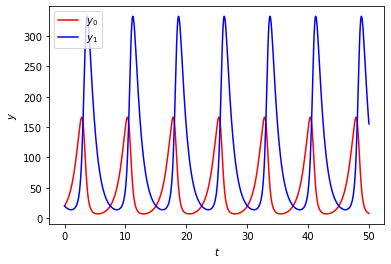

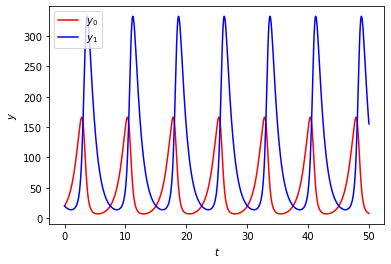

42.2 ms ± 668 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
42.2 ms ± 668 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
# Test python
time_domain, y_results, success, message = nbrk_ode_py(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)


%timeit nbrk_ode_py(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)

N:\Joe Documents\Research\Software\CyRK\CyRK\nbrk.py:314: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 1d, C))
  y_new = y_now + step * np.dot(K[:-1].T, B)
N:\Joe Documents\Research\Software\CyRK\CyRK\nbrk.py:314: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 1d, C))
  y_new = y_now + step * np.dot(K[:-1].T, B)
N:\Joe Documents\Research\Software\CyRK\CyRK\nbrk.py:314: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 1d, C))
  y_new = y_now + step * np.dot(K[:-1].T, B)
N:\Joe Documents\Research\Software\CyRK\CyRK\nbrk.py:314: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 1d, C))
  y_new = y_now + step * np.dot(K[:-1].T, B)
C:\ProgramData\Anaconda3\envs\arpy\lib\site-packages\matplotlib\cbook\__

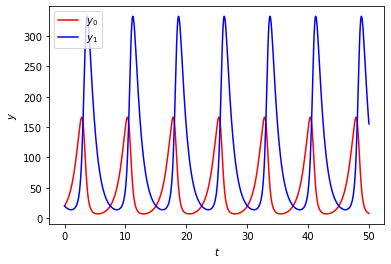

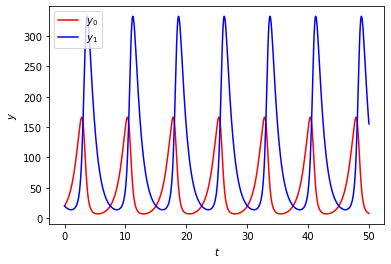

1.89 ms ± 16.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.89 ms ± 16.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
# Test Numba - RK45
time_domain, y_results, success, message = nbrk_ode(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)

%timeit nbrk_ode(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)

Finished
Finished


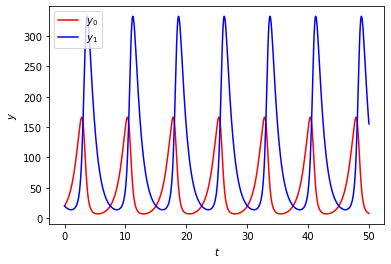

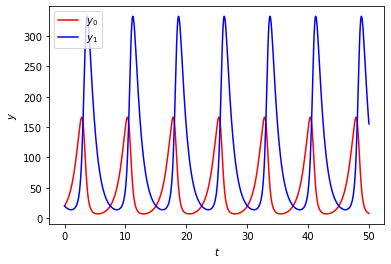

2.71 ms ± 28.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.71 ms ± 28.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
# Test Cython - RK45

# 60ms
# 53.5ms
# 56.7ms, 56.1ms
# 56.8ms
# 47.8ms
# 36ms
# 35ms
# 26.9ms
# 26.6ms
# started adding mem views and it sucks now. 55ms
# 21.5ms
# 17.6ms
# 17ms
# 16.8ms
# 14.6ms
# 9.16ms
# 8.62ms
# 6.14ms
# 4.41ms
# 4.33ms
# 4.25ms
# 4.1ms
# 4.15ms
# 4.08ms
# 4.07ms
# 3.94ms
# 3.49ms
# 3.43ms
# 3.33ms
# 3.25ms
# 2.96ms
# 2.92ms
# 2.78ms
# 2.55ms
# 2.33ms
# 2.82ms  (added teval functionality)
# 2.61ms
# 2.73ms  (added DOP)
# 2.63ms
# 2.45ms

time_domain, y_results, success, message = rk_integrate_cy(y_diff2, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, rk_method=1)
print(message)
diff_plot(time_domain, y_results)

%timeit rk_integrate_cy(y_diff2, time_span, initial_conds, rtol=rtol, atol=atol, rk_method=1)

### Check DOP

C:\ProgramData\Anaconda3\envs\arpy\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\ProgramData\Anaconda3\envs\arpy\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


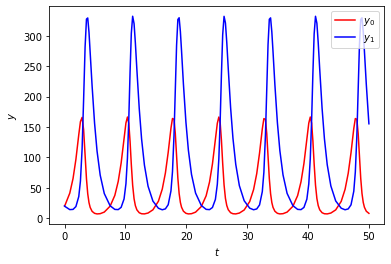

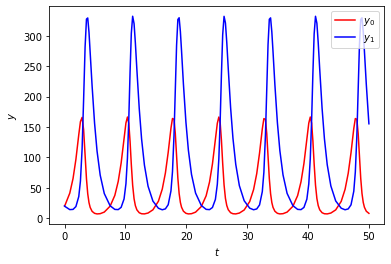

1.65 ms ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.65 ms ± 18.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
# Test Numba - DOP
time_domain, y_results, success, message = nbrk_ode(y_diff, time_span, initial_conds, rtol=rtol, atol=atol, rk_method=2)
diff_plot(time_domain, y_results)

%timeit nbrk_ode(y_diff, time_span, initial_conds, rtol=rtol, atol=atol, rk_method=2)

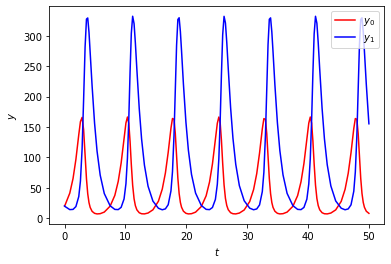

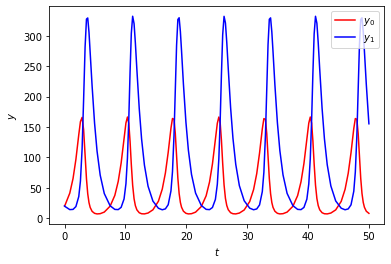

2.53 ms ± 43.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.53 ms ± 43.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
# Test Cython - DOP
# 4ms
# 2.92ms
# 2.8ms
# 2.65ms
# 2.51ms


time_domain, y_results, success, message = rk_integrate_cy(y_diff2, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, rk_method=2)
diff_plot(time_domain, y_results)

%timeit rk_integrate_cy(y_diff2, time_span, initial_conds, rtol=rtol, atol=atol, rk_method=2)

### Check t_eval

In [29]:
teval = np.linspace(0., time_span[1], 50)

N:\Joe Documents\Research\Software\CyRK\CyRK\nbrk.py:314: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 1d, C))
  y_new = y_now + step * np.dot(K[:-1].T, B)
N:\Joe Documents\Research\Software\CyRK\CyRK\nbrk.py:314: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 1d, C))
  y_new = y_now + step * np.dot(K[:-1].T, B)
N:\Joe Documents\Research\Software\CyRK\CyRK\nbrk.py:314: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 1d, C))
  y_new = y_now + step * np.dot(K[:-1].T, B)
N:\Joe Documents\Research\Software\CyRK\CyRK\nbrk.py:314: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 1d, C))
  y_new = y_now + step * np.dot(K[:-1].T, B)
C:\ProgramData\Anaconda3\envs\arpy\lib\site-packages\matplotlib\cbook\__

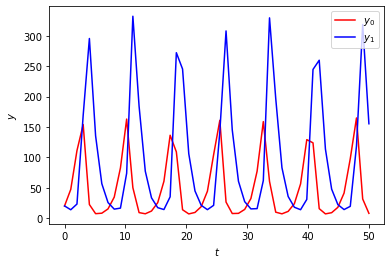

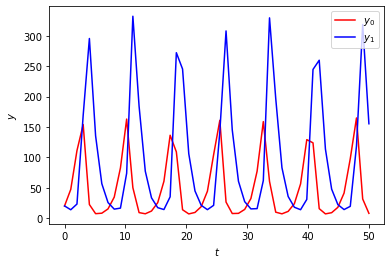

1.93 ms ± 32.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.93 ms ± 32.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [30]:
# Test Numba - t_eval
time_domain, y_results, success, message = nbrk_ode(y_diff, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, t_eval=teval)
diff_plot(time_domain, y_results)

%timeit nbrk_ode(y_diff, time_span, initial_conds, rtol=rtol, atol=atol, t_eval=teval)

Finished
Finished


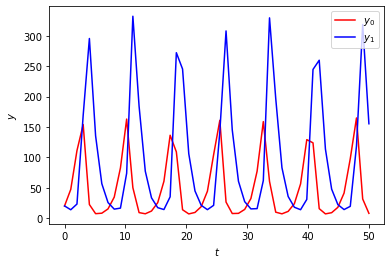

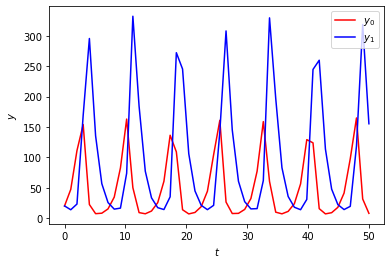

2.91 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.91 ms ± 122 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
# Test Cython - t_eval
# 2.74ms
time_domain, y_results, success, message = rk_integrate_cy(y_diff2, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, t_eval=teval)
print(message)
diff_plot(time_domain, y_results)

%timeit rk_integrate_cy(y_diff2, time_span, initial_conds, rtol=rtol, atol=atol, t_eval=teval)